In [4]:
import glob
import os
# path = input('''This is for X-ray data set. Please copy and paste path to your local data dir:
# blank will be set to current directory  ''')
# if path in (''):
#     path = os.getcwd()
# os.chdir(path)
std_list = glob.glob('../data/*.tif')
dark_list = []
for el in std_list:
    if 'dark' in el:
        dark_list.append(el)
        std_list.remove(el)
print('std_list = {}'.format(std_list))
print('dark_list = {}'.format(dark_list))

std_list = ['../data/AB1-269-CdSe_140mm_100K-00264.dark.tif', '../data/AB1-269-CdSe_140mm_100K-00264.tif', '../data/AB1-269-CdSe_140mm_100K-00268.tif', '../data/AB1-275-CdOBz2_140mm_100K-00304.tif', '../data/AB1-275-CdSe-bulk_140mm_100K-00307.tif', '../data/AB1-275-CdSe_140mm_100K-00297.tif', '../data/AB1-275-CdSe_140mm_100K-00299.tif', '../data/Ba070K030Zn095Mn005As2_140mm_199K-00384.tif', '../data/Ba070K030Zn095Mn005As2_140mm_239K-00380.tif', '../data/Ba070K030Zn095Mn005As2_140mm_259K-00378.tif', '../data/Ba070K030Zn095Mn005As2_140mm_279K-00377.tif', '../data/BaFe2Se2O-B437_140mm_110K-00427.tif', '../data/BaFe2Se2O-B437_140mm_122K-00434.tif', '../data/BaFe2Se2O-B437_140mm_131K-00438.tif', '../data/BaFe2Se2O-B437_140mm_132K-00439.tif', '../data/BaFe2Se2O-B437_140mm_139K-00442.tif', '../data/BaFe2Se2O-B437_140mm_161K-00453.tif', '../data/BaFe2Se2O-B437_140mm_167K-00456.tif', '../data/BaFe2Se2O-B437_140mm_201K-00474.dark.tif', '../data/BaFe2Se2O-B437_140mm_205K-00475.tif', '../data/BaFe

In [5]:
import tifffile as tif
import numpy as np
import math
import pandas as pd

from skimage import data, io, transform
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

%matplotlib inline

classes = {"experiment":0, "black":1, "white":2,"random":3}
num_dummies = 50

def read_in_array(f_list):
    first_ob= tif.imread(f_list[0])
    obs_len = len(f_list)
    print(obs_len)
    obs_dim = np.shape(first_ob)
    #print(obs_dim)
    pixel_len = obs_dim[0]*obs_dim[1]
    print(pixel_len)
    img_array = []
    for el in f_list:
        img_read = tif.imread(el)
        np.reshape(img_read,(1, pixel_len))
        img_array.append(img_read)
    out= np.reshape(img_array, (obs_len, pixel_len))
    print('dim of img_array = {}'.format(np.shape(out)))
    return out

In [6]:
img_array = read_in_array(std_list)

117
4194304
dim of img_array = (117, 4194304)


In [7]:
len(img_array)

117

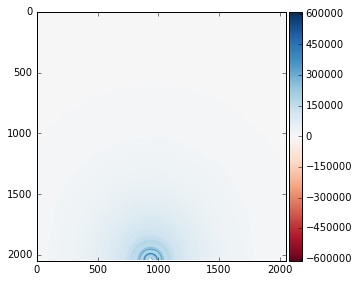

In [8]:
training_images = []
training_labels = []
for img in img_array:
    reshaped = np.reshape(img,(2048,2048))
    training_images.append(reshaped)
    training_labels.append(1)
io.imshow(training_images[2])

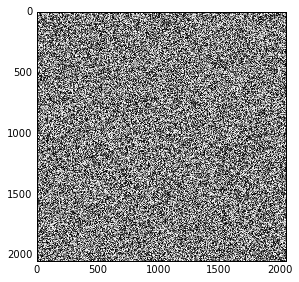

In [9]:
rand_images = np.random.rand(num_dummies, 2048, 2048)
rand_labels = []

for i in range(0,num_dummies):
    rand_labels.append(classes['random'])
io.imshow(rand_images[2])

100

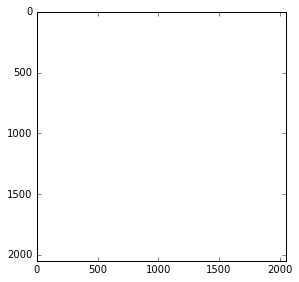

In [10]:
white_black_images = []
white_black_labels = []
num_zero = 1
for i in range(0,num_dummies):
    black_image = np.zeros((2048,2048))
    white_black_images.append(black_image)
    white_black_labels.append(classes['black'])
    white_image = np.ones((2048,2048))
    white_black_images.append(white_image)
    white_black_labels.append(classes['white'])
io.imshow(white_black_images[1])
len(white_black_images)

# Load some real data

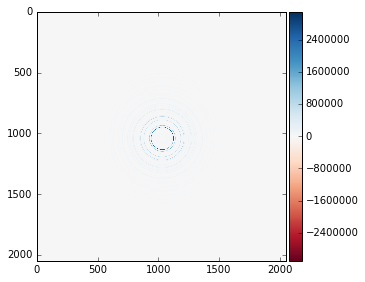

In [28]:
#filename = "./data/K08Fe2-xNixSe2-x100-B817_400mm_300K-00129.tif"
filename = "./Ni_300K-00044.tif"
#arr = np.array([[4,4,1],[0,-1,-2],[1,4,4]])
image = io.imread(filename)
io.imshow(image)

# Sample the data

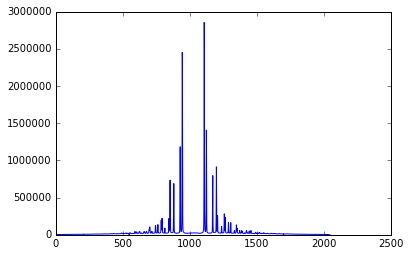

In [36]:
import matplotlib.pyplot as plt
plt.plot(image[1000])

In [43]:
def log_resize(arr, threshold=1e-5, size=None):
    import skimage.transform
    arr[arr <= 0] = threshold
    arr = np.log(arr)
    if size != len(arr):
        arr = transform.resize(arr.astype(float), (size,size))
    return arr

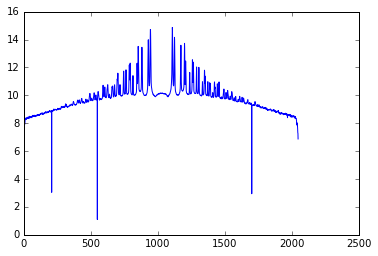

In [45]:
image_size = 2048
image_log = log_resize(image,size=image_size)
#io.imshow(image_log)
plt.plot(image_log[1000])
#io.imshow(image)



In [174]:
import pandas as pd
from scipy.stats import threshold as _threshold


def get_threshold_cuts(signal, threshold):
    #Given a cut across the data, threshold and return the index of the first and last point
    thresholded = _threshold(signal, threshold)
    non_zero =  np.where(thresholded!=0)
    return (non_zero[0][0], non_zero[0][-1])


#####
image_size = 2048
delta = 10
num = 5
threshold = 10
center = image_size/2
cuts = []
# The center of the image i.e. pixel image_size/2 is taken as the center. Cut locations
# are then built using the delta * iterate(number) away from the center
cut_locations = []
for i in range(0,num):
    cut_locations.append(center+(i*delta))
    if i != 0:
        cut_locations.append(center-(i*delta))

#Calculate the start and end cut points based on thresholding at the cut location       
for cut_location in cut_locations:
    cut_points = get_threshold_cuts(image_log[cut_location], threshold=threshold)  
    cuts.append(cut_points)

df = pd.DataFrame(cuts, columns=['start','end']) 
df.mean()

start     489.222222
end      1556.333333
dtype: float64

In [173]:
df

,start,end
0,488,1557
1,494,1551
2,501,1544
3,520,1525
4,535,1511
5,568,1540
6,592,1453
7,647,1472
8,688,1440
